In [4]:
# multichannel multi-step cnn
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# multi headed multi-step cnn

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Model
from keras.layers import Input
from keras.layers.merge import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from keras.models import load_model
from keras.models import load_model
import matplotlib.pyplot as plt

import pickle
import numpy as np

In [35]:
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[0:95016], data[95016:103776]
	# restructure into windows of 6hours data
	train = array(split(train, len(train)/12))
	test = array(split(test, len(test)/12))
	return train, test

In [3]:
# split a univariate dataset into train/test sets
#根据需求更改
def split_dataset(train, test):
	# split into standard weeks
	#train, test = data[0:95016], data[95016:103776]
	# restructure into windows of 6hours data
	train = array(split(train, len(train)/6))
	test = array(split(test, len(test)/6))
	return train, test

In [36]:
dataset = read_csv('../data/selected_data_ISONE1.csv', header=0, infer_datetime_format=True, parse_dates=['date'], index_col=['date'])
data = dataset.values
# split into train and test
train, test = split_dataset(data)
print(train)

[[[1.2863e+04 2.3000e+01]
  [1.2389e+04 2.2000e+01]
  [1.2155e+04 2.1000e+01]
  ...
  [1.5647e+04 2.7000e+01]
  [1.5653e+04 3.0000e+01]
  [1.5416e+04 3.3000e+01]]

 [[1.4994e+04 3.5000e+01]
  [1.4581e+04 3.7000e+01]
  [1.4335e+04 3.7000e+01]
  ...
  [1.4753e+04 3.4000e+01]
  [1.3757e+04 3.3000e+01]
  [1.2707e+04 3.3000e+01]]

 [[1.1861e+04 3.2000e+01]
  [1.1373e+04 3.2000e+01]
  [1.1085e+04 3.2000e+01]
  ...
  [1.4438e+04 3.4000e+01]
  [1.5055e+04 3.4000e+01]
  [1.5407e+04 3.4000e+01]]

 ...

 [[1.6046e+04 3.5000e+01]
  [1.6001e+04 3.5000e+01]
  [1.6002e+04 3.3000e+01]
  ...
  [1.6758e+04 1.9000e+01]
  [1.5526e+04 1.7000e+01]
  [1.4313e+04 1.6000e+01]]

 [[1.3429e+04 1.5000e+01]
  [1.3009e+04 1.3000e+01]
  [1.2795e+04 1.3000e+01]
  ...
  [1.7351e+04 1.3000e+01]
  [1.7430e+04 1.5000e+01]
  [1.7306e+04 1.7000e+01]]

 [[1.7050e+04 1.9000e+01]
  [1.6907e+04 2.1000e+01]
  [1.6767e+04 2.2000e+01]
  ...
  [1.6172e+04 2.0000e+01]
  [1.5355e+04 2.0000e+01]
  [1.4605e+04 2.0000e+01]]]


In [37]:
n_input = 12

In [38]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	#verbose, epochs, batch_size = 1, 6, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	#model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [39]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=12):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [40]:
# evaluate a single model
def evaluate_model(train, test, n_input,model):
	# fit model
	#model = modeltest
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

In [41]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=1)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [42]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [43]:
from keras.models import load_model

import pickle
all_mae_histories = []
verbose, epochs, batch_size = 1, 3, 16
train_x, train_y = to_supervised(train, n_input)
model = build_model(train, n_input)

history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)

mae_history = history.history['loss']
all_mae_histories.append(mae_history)


file = open('history81.pkl', 'wb')
pickle.dump(all_mae_histories, file)
file.close()

model.save('model81.h5')

Epoch 1/3
94992/94992 [==============================] - 31s 322us/step - loss: 3880684.1136
Epoch 2/3
94992/94992 [==============================] - 31s 323us/step - loss: 1141645.7024
Epoch 3/3
94992/94992 [==============================] - 32s 333us/step - loss: 949664.9619


In [ ]:
from keras.models import load_model

model = load_model('model63.h5')

file = open('history63.pkl', 'rb')

a = pickle.load(file)

In [ ]:
all_mae_histories


In [47]:
import numpy as np
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(epochs)]

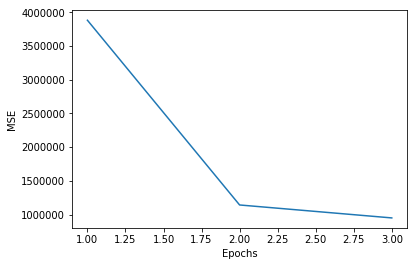

In [48]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [49]:
score, scores = evaluate_model(train, test, n_input,model)
# summarize scores
summarize_scores('cnn', score, scores)

1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 995us/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step
cnn: [775.840] 410.8, 622.4, 496.8, 581.1, 719.8, 879.2, 1002.8, 959.7, 854.7, 795.1, 821.6, 909.6


In [ ]:
# multi headed multi-step cnn
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Model
from keras.layers import Input
from keras.layers.merge import concatenate

# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# plot training history
def plot_history(history):
	# plot loss
	pyplot.subplot(2, 1, 1)
	pyplot.plot(history.history['loss'], label='train')
	pyplot.plot(history.history['val_loss'], label='test')
	pyplot.title('loss', y=0, loc='center')
	pyplot.legend()
	# plot rmse
	pyplot.subplot(2, 1, 2)
	pyplot.plot(history.history['rmse'], label='train')
	pyplot.plot(history.history['val_rmse'], label='test')
	pyplot.title('rmse', y=0, loc='center')
	pyplot.legend()
	pyplot.show()

# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 25, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# create a channel for each variable
	in_layers, out_layers = list(), list()
	for i in range(n_features):
		inputs = Input(shape=(n_timesteps,1))
		conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
		conv2 = Conv1D(filters=32, kernel_size=3, activation='relu')(conv1)
		pool1 = MaxPooling1D(pool_size=2)(conv2)
		flat = Flatten()(pool1)
		# store layers
		in_layers.append(inputs)
		out_layers.append(flat)
	# merge heads
	merged = concatenate(out_layers)
	# interpretation
	dense1 = Dense(200, activation='relu')(merged)
	dense2 = Dense(100, activation='relu')(dense1)
	outputs = Dense(n_outputs)(dense2)
	model = Model(inputs=in_layers, outputs=outputs)
	# compile model
	model.compile(loss='mse', optimizer='adam')
	# fit network
	input_data = [train_x[:,:,i].reshape((train_x.shape[0],n_timesteps,1)) for i in range(n_features)]
	model.fit(input_data, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into n input arrays
	input_x = [input_x[:,i].reshape((1,input_x.shape[0],1)) for i in range(input_x.shape[1])]
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='cnn')
pyplot.show()

In [148]:
# multi headed multi-step cnn
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Model
from keras.layers import Input
from keras.layers.merge import concatenate
from sklearn.preprocessing import MinMaxScaler

import numpy as np



In [149]:
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[0:95016], data[95016:103776]
	# restructure into windows of 6hours data
	train = array(split(train, len(train)/24))
	test = array(split(test, len(test)/24))
	return train, test

In [150]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [151]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=24):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [152]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)

	# define parameters
	verbose, epochs, batch_size = 1, 6, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# create a channel for each variable
	in_layers, out_layers = list(), list()
	for i in range(n_features):
		inputs = Input(shape=(n_timesteps,1))
		conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
		conv2 = Conv1D(filters=32, kernel_size=3, activation='relu')(conv1)
		pool1 = MaxPooling1D(pool_size=2)(conv2)
		flat = Flatten()(pool1)
		# store layers
		in_layers.append(inputs)
		out_layers.append(flat)
	# merge heads
	merged = concatenate(out_layers)
	# interpretation
	dense1 = Dense(200, activation='relu')(merged)
	dense2 = Dense(100, activation='relu')(dense1)
	outputs = Dense(n_outputs)(dense2)
	model = Model(inputs=in_layers, outputs=outputs)
	# compile model
	model.compile(loss='mse', optimizer='adam')
	# fit network
	input_data = [train_x[:,:,i].reshape((train_x.shape[0],n_timesteps,1)) for i in range(n_features)]
	#model.fit(input_data, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model,input_data

In [153]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into n input arrays
	input_x = [input_x[:,i].reshape((1,input_x.shape[0],1)) for i in range(input_x.shape[1])]
	# forecast the next week
	yhat = model.predict(input_x, verbose=1)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [154]:
# evaluate a single model
#def evaluate_model(train, test, n_input):
def evaluate_model(train, test, n_input,model):
	# fit model
	#model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
        
	#score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return predictions, test[:, :, 0]

In [155]:

dataset = read_csv('../data/selected_data_ISONE1.csv', header=0, infer_datetime_format=True, parse_dates=['date'], index_col=['date'])
data = dataset.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
# split into train and test
train, test = split_dataset(data)
# evaluate model and get scores
n_input = 24

In [156]:
from keras.models import load_model

import pickle
all_mae_histories = []
verbose, epochs, batch_size = 1, 3, 16
train_x, train_y = to_supervised(train, n_input)
model,input_data = build_model(train, n_input)
history = model.fit(input_data, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)

mae_history = history.history['loss']
all_mae_histories.append(mae_history)


file = open('history80.pkl', 'wb')
pickle.dump(all_mae_histories, file)
file.close()

model.save('model80.h5')

Epoch 1/3
94968/94968 [==============================] - 37s 390us/step - loss: 0.0031
Epoch 2/3
94968/94968 [==============================] - 36s 376us/step - loss: 0.0020
Epoch 3/3
94968/94968 [==============================] - 36s 374us/step - loss: 0.0018


In [ ]:
from keras.models import load_model

model = load_model('model77.h5')

file = open('history77.pkl', 'rb')

a = pickle.load(file)

In [44]:
import numpy as np
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(epochs)]

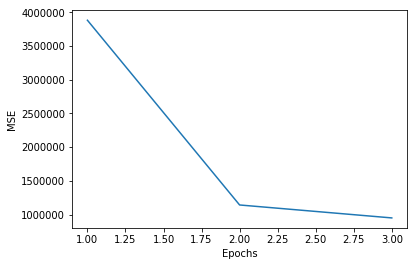

In [45]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [46]:
pre, act = evaluate_model(train, test, n_input,model)
score, scores = evaluate_forecasts(pre, act)

# summarize scores
summarize_scores('cnn', score, scores)

1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


AttributeError: 'float' object has no attribute 'shape'

In [160]:
act

array([[0.30396409, 0.27667944, 0.25675812, ..., 0.42187815, 0.35898729,
        0.30204761],
       [0.26462578, 0.24652007, 0.23819851, ..., 0.51760137, 0.45455921,
        0.3978717 ],
       [0.35949163, 0.33533387, 0.32650797, ..., 0.54498689, 0.4866855 ,
        0.43050232],
       ...,
       [0.16804519, 0.14661085, 0.13909623, ..., 0.39202138, 0.32837402,
        0.26810571],
       [0.22654832, 0.20445834, 0.19613678, ..., 0.43695784, 0.372907  ,
        0.31258826],
       [0.27022393, 0.24571313, 0.23461771, ..., 0.38990317, 0.35127093,
        0.31657252]])

In [161]:
pre

array([[0.26136398, 0.23689565, 0.22994977, ..., 0.39558917, 0.35276112,
        0.30252224],
       [0.24014403, 0.22909345, 0.2134299 , ..., 0.43607783, 0.36700502,
        0.2888886 ],
       [0.33793044, 0.32308608, 0.30589774, ..., 0.47087795, 0.40782484,
        0.33790743],
       ...,
       [0.14857274, 0.12252226, 0.10775746, ..., 0.35441092, 0.29609385,
        0.22744349],
       [0.20262322, 0.17659529, 0.16272014, ..., 0.3830877 , 0.3219268 ,
        0.25345454],
       [0.2493335 , 0.23025477, 0.22025365, ..., 0.4199916 , 0.35682806,
        0.28428313]], dtype=float32)

In [162]:
scores

[0.01831802427102459,
 0.03172223425603852,
 0.018584075381121768,
 0.018722852185127717,
 0.02154340038649928,
 0.027990891171783338,
 0.039972652404099175,
 0.04300748988434171,
 0.03697679479959239,
 0.0388702522306334,
 0.04173416814307564,
 0.04338232036585667,
 0.04690508799837884,
 0.048626128784342644,
 0.05207485033665848,
 0.05550718137360234,
 0.05510002279314449,
 0.05371446787237723,
 0.052219432742498274,
 0.04908853953122183,
 0.045609538423620595,
 0.042748324256585285,
 0.03827907096827338,
 0.03798924634398843]

In [163]:
score

0.041566277134362055

In [26]:
dataset.values.shape

(103776, 2)

In [33]:
test.shape

(365, 24, 2)

In [35]:
#数组行数
len(test)

365

In [168]:
#3维数组还原2维数组
a = test.reshape([len(test)*24,2])
a

array([[0.30396409, 0.25233645],
       [0.27667944, 0.24299065],
       [0.25675812, 0.22429907],
       ...,
       [0.38990317, 0.26168224],
       [0.35127093, 0.23364486],
       [0.31657252, 0.24299065]])

In [169]:
#去标准化，还原原值
inv_test = scaler.inverse_transform(a)
inv_test

array([[13821.,    20.],
       [13280.,    19.],
       [12885.,    17.],
       ...,
       [15525.,    21.],
       [14759.,    18.],
       [14071.,    19.]])

In [166]:
pre

array([[0.26136398, 0.23689565, 0.22994977, ..., 0.39558917, 0.35276112,
        0.30252224],
       [0.24014403, 0.22909345, 0.2134299 , ..., 0.43607783, 0.36700502,
        0.2888886 ],
       [0.33793044, 0.32308608, 0.30589774, ..., 0.47087795, 0.40782484,
        0.33790743],
       ...,
       [0.14857274, 0.12252226, 0.10775746, ..., 0.35441092, 0.29609385,
        0.22744349],
       [0.20262322, 0.17659529, 0.16272014, ..., 0.3830877 , 0.3219268 ,
        0.25345454],
       [0.2493335 , 0.23025477, 0.22025365, ..., 0.4199916 , 0.35682806,
        0.28428313]], dtype=float32)

In [170]:
b = pre.reshape([len(prediction)*24,1])
b

array([[0.26136398],
       [0.23689565],
       [0.22994977],
       ...,
       [0.4199916 ],
       [0.35682806],
       [0.28428313]], dtype=float32)

In [171]:
#去掉第一列
c = a[:,-1 :]
c

array([[0.25233645],
       [0.24299065],
       [0.22429907],
       ...,
       [0.26168224],
       [0.23364486],
       [0.24299065]])

In [91]:
a.dtype = 'float32'
a

array([[-3.7506237e+08,  1.6519819e+00, -1.8987064e+04,  1.6261681e+00],
       [-7.7091036e-09,  1.6383396e+00,  1.1785119e+15,  1.6179906e+00],
       [-3.8694900e-22,  1.6283790e+00, -5.9606229e+28,  1.5992990e+00],
       ...,
       [ 3.7671076e+25,  1.6949515e+00, -1.3240279e+20,  1.6308410e+00],
       [ 1.1999980e-28,  1.6756355e+00,  2.4642799e-17,  1.6086448e+00],
       [ 6.4080148e+23,  1.6582862e+00,  1.1785119e+15,  1.6179906e+00]],
      dtype=float32)

In [172]:
inv_e = np.concatenate((b, c), axis=1)
inv_e

array([[0.26136398, 0.25233645],
       [0.23689565, 0.24299065],
       [0.22994977, 0.22429907],
       ...,
       [0.41999161, 0.26168224],
       [0.35682806, 0.23364486],
       [0.28428313, 0.24299065]])

In [184]:
inv_test1 = array(split(inv_test, len(inv_test)/24))
inv_test1

array([[[ 1.3821e+04,  2.0000e+01],
        [ 1.3280e+04,  1.9000e+01],
        [ 1.2885e+04,  1.7000e+01],
        ...,
        [ 1.6159e+04,  2.1000e+01],
        [ 1.4912e+04,  2.0000e+01],
        [ 1.3783e+04,  2.0000e+01]],

       [[ 1.3041e+04,  1.9000e+01],
        [ 1.2682e+04,  1.8000e+01],
        [ 1.2517e+04,  1.7000e+01],
        ...,
        [ 1.8057e+04,  5.0000e+00],
        [ 1.6807e+04,  4.0000e+00],
        [ 1.5683e+04,  3.0000e+00]],

       [[ 1.4922e+04,  2.0000e+00],
        [ 1.4443e+04,  2.0000e+00],
        [ 1.4268e+04,  2.0000e+00],
        ...,
        [ 1.8600e+04,  1.0000e+00],
        [ 1.7444e+04,  0.0000e+00],
        [ 1.6330e+04, -1.0000e+00]],

       ...,

       [[ 1.1126e+04,  3.7000e+01],
        [ 1.0701e+04,  3.6000e+01],
        [ 1.0552e+04,  3.5000e+01],
        ...,
        [ 1.5567e+04,  3.0000e+01],
        [ 1.4305e+04,  2.9000e+01],
        [ 1.3110e+04,  2.8000e+01]],

       [[ 1.2286e+04,  2.7000e+01],
        [ 1.1848e+04,  2.60

In [185]:
ttt = inv_test1[:, :, 0]
ttt

array([[13821., 13280., 12885., ..., 16159., 14912., 13783.],
       [13041., 12682., 12517., ..., 18057., 16807., 15683.],
       [14922., 14443., 14268., ..., 18600., 17444., 16330.],
       ...,
       [11126., 10701., 10552., ..., 15567., 14305., 13110.],
       [12286., 11848., 11683., ..., 16458., 15188., 13992.],
       [13152., 12666., 12446., ..., 15525., 14759., 14071.]])

In [173]:
inv_pre = scaler.inverse_transform(inv_e)
inv_pre

array([[12976.32505798,    20.        ],
       [12491.1669606 ,    19.        ],
       [12353.44408631,    17.        ],
       ...,
       [16121.59369135,    21.        ],
       [14869.18684757,    18.        ],
       [13430.76592863,    19.        ]])

In [178]:
inv_pre1 = array(split(inv_pre, len(inv_pre)/24))
inv_pre1

array([[[ 1.29763251e+04,  2.00000000e+01],
        [ 1.24911670e+04,  1.90000000e+01],
        [ 1.23534441e+04,  1.70000000e+01],
        ...,
        [ 1.56377421e+04,  2.10000000e+01],
        [ 1.47885475e+04,  2.00000000e+01],
        [ 1.37924110e+04,  2.00000000e+01]],

       [[ 1.25555758e+04,  1.90000000e+01],
        [ 1.23364649e+04,  1.80000000e+01],
        [ 1.20258880e+04,  1.70000000e+01],
        ...,
        [ 1.64405513e+04,  5.00000000e+00],
        [ 1.50709755e+04,  4.00000000e+00],
        [ 1.35220832e+04,  3.00000000e+00]],

       [[ 1.44944848e+04,  2.00000000e+00],
        [ 1.42001509e+04,  2.00000000e+00],
        [ 1.38593404e+04,  2.00000000e+00],
        ...,
        [ 1.71305679e+04,  1.00000000e+00],
        [ 1.58803510e+04,  0.00000000e+00],
        [ 1.44940286e+04, -1.00000000e+00]],

       ...,

       [[ 1.07399003e+04,  3.70000000e+01],
        [ 1.02233715e+04,  3.60000000e+01],
        [ 9.93061500e+03,  3.50000000e+01],
        ...,
     

In [182]:
#
ppp = inv_pre1[:, :, 0]
ppp

array([[12976.32505798, 12491.1669606 , 12353.44408631, ...,
        15637.74211907, 14788.54747951, 13792.41101575],
       [12555.57581216, 12336.46487361, 12025.88801801, ...,
        16440.55127621, 15070.9755441 , 13522.08322918],
       [14494.48478222, 14200.15085244, 13859.34043849, ...,
        17130.56790185, 15880.35100925, 14494.02859163],
       ...,
       [10739.90034699, 10223.37146485,  9930.61499721, ...,
        14821.25965369, 13664.94888413, 12303.74944937],
       [11811.61317241, 11295.53132159, 11020.41501117, ...,
        15389.86280942, 14177.16463792, 12819.49654377],
       [12737.78465509, 12359.49156618, 12161.1893003 , ...,
        16121.59369135, 14869.18684757, 13430.76592863]])

In [183]:
ppp[:, 1]

array([12491.1669606 , 12336.46487361, 14200.15085244, 14736.87503183,
       12889.0124253 , 11444.03553945, 11926.65888357, 14387.20849311,
       13617.06482744, 13478.7392143 , 12011.11825687, 10845.76197255,
       10687.69636637, 10925.42720824, 10786.55617553, 11112.04490864,
       11201.62490308, 11223.21477258, 11374.39024633, 11265.03923553,
       12036.8862294 , 13879.81642294, 14176.54298961, 13939.62407243,
       13659.83210397, 12304.54187369, 12604.68396056, 13171.62781167,
       13577.98607635, 13420.29954565, 13183.8959111 , 11801.84555286,
       11244.34786057, 10789.46439052, 11968.42248172, 12021.03390199,
       12264.39592028, 12857.22149611, 12570.31189084, 12209.99637473,
       11921.97170258, 13218.63730609, 13567.90970087, 13265.20656478,
       12033.03106439, 11756.91107559, 11575.45122433, 12056.65163201,
       13130.26988041, 12760.48663688, 11795.42490673, 11381.80157059,
       11159.90946496, 10916.95045441, 10464.37393779, 12286.18227082,
      

In [132]:
summarize_scores('cnn', score, scores)

cnn: [510.348] 721.7, 0.0


In [124]:
scores

[14683.249903591055, 52.24877744937098]

In [ ]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, 1], predicted[:, 1])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [188]:
score11, scores22 = evaluate_forecasts(ttt, ppp)


In [191]:
score11

824.1761430201294

In [190]:
scores22

[363.209785245875,
 628.9884608287317,
 368.485046656882,
 371.236713126712,
 427.16254286350744,
 555.00339015412,
 792.5777518684782,
 852.7525094267273,
 733.1758872863181,
 770.7193612289992,
 827.505085940904,
 860.1846482142063,
 930.0340848318559,
 964.158881535946,
 1032.5401324752645,
 1100.5963922757874,
 1092.5232519424692,
 1065.0504689734958,
 1035.406912418256,
 973.3275618250666,
 904.3459278635494,
 847.6137733595731,
 758.9974191589246,
 753.2507765086025]

In [193]:
summarize_scores('cnn', score11, scores22)

cnn: [824.176] 363.2, 629.0, 368.5, 371.2, 427.2, 555.0, 792.6, 852.8, 733.2, 770.7, 827.5, 860.2, 930.0, 964.2, 1032.5, 1100.6, 1092.5, 1065.1, 1035.4, 973.3, 904.3, 847.6, 759.0, 753.3


In [165]:
pre

array([[0.26136398, 0.23689565, 0.22994977, ..., 0.39558917, 0.35276112,
        0.30252224],
       [0.24014403, 0.22909345, 0.2134299 , ..., 0.43607783, 0.36700502,
        0.2888886 ],
       [0.33793044, 0.32308608, 0.30589774, ..., 0.47087795, 0.40782484,
        0.33790743],
       ...,
       [0.14857274, 0.12252226, 0.10775746, ..., 0.35441092, 0.29609385,
        0.22744349],
       [0.20262322, 0.17659529, 0.16272014, ..., 0.3830877 , 0.3219268 ,
        0.25345454],
       [0.2493335 , 0.23025477, 0.22025365, ..., 0.4199916 , 0.35682806,
        0.28428313]], dtype=float32)

In [164]:
pre[:, 1]

array([0.23689565, 0.22909345, 0.32308608, 0.3501551 , 0.25696048,
       0.1840849 , 0.2084254 , 0.3325201 , 0.29367888, 0.2867026 ,
       0.212685  , 0.15391174, 0.1459399 , 0.15792955, 0.15092577,
       0.16734138, 0.17185923, 0.17294809, 0.18057244, 0.17505746,
       0.21398458, 0.30693042, 0.32189545, 0.30994675, 0.2958358 ,
       0.22748345, 0.24262074, 0.27121383, 0.291708  , 0.28375527,
       0.27183256, 0.2021306 , 0.17401391, 0.15107244, 0.2105317 ,
       0.21318509, 0.22545874, 0.25535715, 0.24088722, 0.22271517,
       0.20818901, 0.2735847 , 0.2911998 , 0.27593336, 0.21379015,
       0.19986439, 0.19071269, 0.21498142, 0.269128  , 0.25047845,
       0.20180678, 0.18094622, 0.16975537, 0.15750204, 0.13467692,
       0.22655751, 0.25755987, 0.28858888, 0.28722274, 0.2912648 ,
       0.20404232, 0.18698123, 0.28712273, 0.24277472, 0.26410273,
       0.2691803 , 0.20415561, 0.16121179, 0.17216742, 0.16746223,
       0.14263073, 0.15679623, 0.2541942 , 0.19676301, 0.14649

In [139]:
inv_test


array([[13821.,    20.],
       [13280.,    19.],
       [12885.,    17.],
       ...,
       [15525.,    21.],
       [14759.,    18.],
       [14071.,    19.]])

In [142]:
inv_test1 = array(split(inv_test, len(inv_test)/24))
inv_test1

array([[[ 1.3821e+04,  2.0000e+01],
        [ 1.3280e+04,  1.9000e+01],
        [ 1.2885e+04,  1.7000e+01],
        ...,
        [ 1.6159e+04,  2.1000e+01],
        [ 1.4912e+04,  2.0000e+01],
        [ 1.3783e+04,  2.0000e+01]],

       [[ 1.3041e+04,  1.9000e+01],
        [ 1.2682e+04,  1.8000e+01],
        [ 1.2517e+04,  1.7000e+01],
        ...,
        [ 1.8057e+04,  5.0000e+00],
        [ 1.6807e+04,  4.0000e+00],
        [ 1.5683e+04,  3.0000e+00]],

       [[ 1.4922e+04,  2.0000e+00],
        [ 1.4443e+04,  2.0000e+00],
        [ 1.4268e+04,  2.0000e+00],
        ...,
        [ 1.8600e+04,  1.0000e+00],
        [ 1.7444e+04,  0.0000e+00],
        [ 1.6330e+04, -1.0000e+00]],

       ...,

       [[ 1.1126e+04,  3.7000e+01],
        [ 1.0701e+04,  3.6000e+01],
        [ 1.0552e+04,  3.5000e+01],
        ...,
        [ 1.5567e+04,  3.0000e+01],
        [ 1.4305e+04,  2.9000e+01],
        [ 1.3110e+04,  2.8000e+01]],

       [[ 1.2286e+04,  2.7000e+01],
        [ 1.1848e+04,  2.60

In [146]:
inv_pre

array([[[ 1.42177047e+04,  2.00000000e+01],
        [ 1.34332324e+04,  1.90000000e+01],
        [ 1.31753802e+04,  1.70000000e+01],
        ...,
        [ 1.54047434e+04,  2.10000000e+01],
        [ 1.46508790e+04,  2.00000000e+01],
        [ 1.42444545e+04,  2.00000000e+01]],

       [[ 1.34996584e+04,  1.90000000e+01],
        [ 1.28795937e+04,  1.80000000e+01],
        [ 1.25785316e+04,  1.70000000e+01],
        ...,
        [ 1.68829817e+04,  5.00000000e+00],
        [ 1.53996207e+04,  4.00000000e+00],
        [ 1.40696874e+04,  3.00000000e+00]],

       [[ 1.52689487e+04,  2.00000000e+00],
        [ 1.45302402e+04,  2.00000000e+00],
        [ 1.42821570e+04,  2.00000000e+00],
        ...,
        [ 1.70231941e+04,  1.00000000e+00],
        [ 1.57913170e+04,  0.00000000e+00],
        [ 1.48814744e+04, -1.00000000e+00]],

       ...,

       [[ 1.15767905e+04,  3.70000000e+01],
        [ 1.08961418e+04,  3.60000000e+01],
        [ 1.07429858e+04,  3.50000000e+01],
        ...,
     

In [ ]:
pre